In [1]:
%env CUDA_VISIBLE_DEVICES=""
import sys
import numpy as np
import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*7)])
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import lib

env: CUDA_VISIBLE_DEVICES=""


In [41]:
n_qubits = 2
dim = 2 ** n_qubits
rho = lib.randomPureState(dim)

measurements_cnt = 1000

sigma = tf.Variable(tf.eye(dim, dtype=tf.complex64) * (2 ** -n_qubits))
sigma_true = tf.Variable(rho, dtype=tf.complex128)

eta = 1e-1 # must be < 0.5
T = 10000

In [42]:
from tqdm.notebook import trange
progress_bar = trange(1, T+1, desc=f'RTFL', leave=True)
global_t = 1
regret = []
for beta in progress_bar:
    if global_t >= T: break
    eta = min(np.sqrt(n_qubits*np.log(2)/(2**beta+1)), 0.5)
    losses = []
    sigma = tf.Variable(tf.eye(dim, dtype=tf.complex128) * (2 ** -n_qubits))
#     sigma = tf.Variable(rho, dtype='complex128')

    for t in range(T):
        global_t += 1
        if global_t >= T: break
        train_X, train_y = lib.generate_dataset(rho, 1, measurements_cnt)
        train_X, train_y = train_X[0], train_y[0]


        train_y = train_y.astype('float64')
        x_var = tf.Variable(train_X, dtype=tf.complex128)
        y_var = tf.Variable(train_y, dtype=tf.complex128)

        trace = tf.linalg.trace(tf.matmul(x_var, sigma))
        trace_true = tf.linalg.trace(tf.matmul(x_var, sigma_true))
        loss = (y_var - trace)**2
        grad = 2*(trace-y_var)*x_var

        losses.append(loss.numpy())
        regret.append(np.real((loss-(y_var-trace_true)**2).numpy()))
        if np.real(sum(losses)) >= 2**beta:
            break
        
        #MEGUPDATE
        G = tf.math.log(sigma - eta*grad)
        sigma = tf.exp(G)
        sigma = tf.Variable(sigma / tf.linalg.trace(sigma))
    progress_bar.set_description('Loss: %.4f Fidelity: %.2f' % (loss.numpy(), 
                                                        lib.utils.fidelity(sigma.numpy(), rho)))
    progress_bar.refresh()

print('Done!')

/home/artem/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


Done!


/home/artem/anaconda3/envs/dl/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


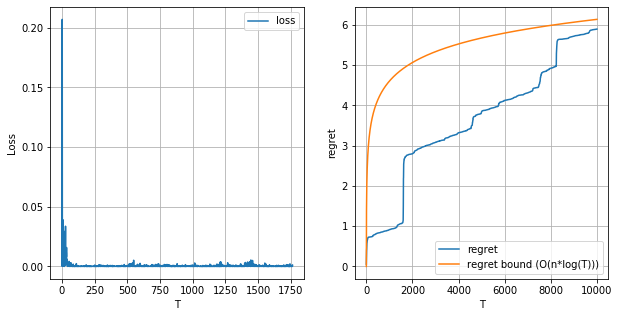

In [45]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.plot(losses, label='loss')
plt.xlabel('T')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
log_step = np.log(1+np.arange(len(regret)))
log_regret = np.log(np.cumsum(regret))
# plt.plot(log_step, log_regret, label='regret')
# plt.plot(log_step, [np.log(regret_bound)]*len(log_step), label='regret bound')
# plt.ylabel('log regret')
# plt.xlabel('log T')
plt.plot(np.cumsum(regret), label='regret')
plt.plot(n_qubits*log_step/3, label='regret bound (O(n*log(T)))')
plt.ylabel('regret')
plt.xlabel('T')

plt.legend()
plt.grid()
plt.show()